In [1]:
import warnings
warnings.filterwarnings("ignore")

Example for blinks tracker and features extraction,

In this example it is conveyed how to go from the EAR extraction from videos to the blinks-based features extractable from the EAR.

please note: This code is thought to be used on a 30fps recording. Some of the parameters should be changed in case you wanted to use it with different fps recording.

Please refer to this article when using the code: "G. Guglielmo, M. Klincewicz, E. Huis in ' Veld and P. Spronck, "Tracking Early Differences in Tetris Performance using Eye Aspect Ratio Extracted Blinks," in IEEE Transactions on Games, doi: 10.1109/TG.2023.3324511."

First load python libraries

In [2]:
import cv2
from cvzone.FaceMeshModule import FaceMeshDetector
from cvzone.PlotModule import LivePlot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import groupby
from sklearn.ensemble import IsolationForest
import more_itertools as mit
from scipy import stats

Now we run the EAR detection code to extract the EAR from a video, you can skip this part and use the EAR_test.csv created for demonstration purpose.

In [ ]:

cap = cv2.VideoCapture(0) # here you can replace it with a directory containing your videom when set to 0 streams real time
detector = FaceMeshDetector(maxFaces= 1)
number_of_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
plotY = LivePlot(640,360, [20,50], invert= True) 
blinkcounter = 0
counter = 0
ratiolist = list()


IdListL = [246, 161, 160, 159, 158, 157, 173,130, 25, 110, 24, 23, 22, 26, 112, 243] # points to track left eye
IdListR = [466, 388, 387, 386, 385, 384, 398, 359, 255, 339, 254, 253, 252, 256, 341, 463] # points to track right eye


while True:
    success, img = cap.read()
    if not success:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    img, faces = detector.findFaceMesh(img, draw= False)

    if faces:
        face = faces[0]
        for iDl in IdListL:
            cv2.circle(img,face[iDl], 1, (255,0,255),1)
        for iDR in IdListR:
            cv2.circle(img,face[iDR], 1, (255,0,255),1)
        leftUp1= face[22]
        leftUp2= face[24]
        leftDown1 = face[158]
        leftDown2 = face[160]
        lengthverL1, _ = detector.findDistance(leftUp1, leftDown1)
        lengthverL2, _ = detector.findDistance(leftUp2, leftDown2)
        #distance itself is not enough, otherwise it will change as I distance myself or get closer
        # we have to take the eye size ratio
        leftLeft = face[130]
        leftRight = face[243]
        lengthhorL, _ = detector.findDistance(leftLeft, leftRight)

        cv2.line(img, leftLeft, leftRight, (0,200,0), 2)
        cv2.line(img, leftUp1, leftDown1, (0,200,0), 2)
        cv2.line(img, leftUp2, leftDown2, (0,200,0), 2)
        RightUp1= face[252]
        RightUp2= face[254]
        RightDown1 = face[385]
        RightDown2 = face[387]
        lengthverR1, _ = detector.findDistance(RightUp1, RightDown1)
        lengthverR2, _ = detector.findDistance(RightUp2, RightDown2)
        #distance itself is not enough, otherwise it will change as I distance myself or get closer
        # we have to take the eye size ratio
        RightLeft = face[359]
        RightRight = face[463]
        lengthhorR, _ = detector.findDistance(RightLeft, RightRight)
        cv2.line(img, RightLeft, RightRight, (0,200,0), 2)
        cv2.line(img, RightUp1, RightDown1, (0,200,0), 2)
        cv2.line(img, RightUp2, RightDown2, (0,200,0), 2)
  

        ratioL = (lengthverL1 + lengthverL2)/(2.0*lengthhorL) # EAR formula for left eye
        ratioR = (lengthverR1 + lengthverR2)/(2.0*lengthhorR) # EAR forumula for right eye
        ratio = ((ratioL + ratioR) /2)*100 # normalization and extraction

        ratiolist.append(ratio)



        imgPlot = plotY.update(ratio)
        cv2.imshow("ImgPlot", imgPlot)

    img = cv2.resize(img, (640,360))
    cv2.imshow("Image", img)
    cv2.waitKey(1)
    pd.Series(ratiolist).to_csv("EAR_test.csv") # you have to save the file here you are streaming real-time, if you are using a video in the directory that has a predefined duration you should put this at the end


cap.release()
cv2.destroyAllWindows()
# pd.Series(ratiolist).to_csv("EAR_test.csv") # here you can save a predefined video you want to extract the EAR from a predefined directory

At this point, we have our file example to work on to extract blinks-based features

In [3]:
example = pd.read_csv("EAR_test.csv", index_col = 0) # example of short EAR recording

example.rename(columns={"0": "EAR_variation"}, inplace=True) # rename for plot purposes

example["EAR_variation"]

0       39.569165
1       39.388516
2       37.459580
3       37.089652
4       38.403305
          ...    
5566    35.441361
5567    34.615747
5568    34.196537
5569    34.702718
5570    34.595584
Name: EAR_variation, Length: 5571, dtype: float64

<AxesSubplot: >

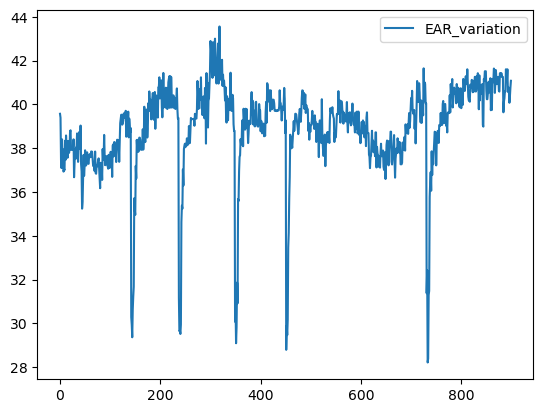

In [4]:
# thirdy seconds of plot (considering 30 fps recording), peaks represent blinks
example[0:900].plot()

Now we have to use to load the functions necessary to extract blinks_based features

In [5]:
from scipy import stats


# this first function is mostly based on the isolation forest authored by  ARJUN SRIDHAR, ASHEN FERNANDO
# you can find the original code at this link: https://github.com/mi3nts/tobiiBlinkDetection/tree/main/Isolation%20Forest

# the values of 2, 4, 15 represent constraints of frames representing milliseconds (2*33.34, 4*33.34, 15*33.34) in a 30 fps recording

# 1 frame = 33.34 ms (approximately)

def isolation_forest(data):

    # number of standard deviations away from the rolling median 
    devs = 2.5

    # size of the rolling window
    roll_window = 100



    # pot_outliers will contain points below 2.5 sigma away from rolling EAR_Avg 
    

    rolling = data['EAR_Avg'].rolling(roll_window).median()
    rolling_abs = rolling - devs*stats.median_abs_deviation(rolling,nan_policy = "omit")
    


    

    pot_outliers = data.loc[data['EAR_Avg'] < rolling_abs]

    # a first order estimation of contamination, a ratio of data 2.5 sigma away from absolute median to total data
    contam = len(pot_outliers)/len(data)

    # implement isolation forest, contamination optimized using the median
    data_np = data['EAR_Avg'].to_numpy().reshape(-1,1)

    model = IsolationForest(n_estimators=100, max_samples='auto', contamination=contam, random_state=1234)

    fit = model.fit(data_np)
    decision = model.decision_function(data_np)
    pred = model.predict(data_np)

    # separate outliers (with a score of -1) from normal samples

    isf = pd.DataFrame({'dec':decision, 'pred':pred})

    ears = pd.DataFrame({'inds':isf.loc[isf['pred'] == -1].index, 'EAR_vals':data['EAR_Avg'][isf.loc[isf['pred'] == -1].index]})
    ears = ears[ears['EAR_vals'] < ears['EAR_vals'].mean()]

    # creates a list of lists that keeps track of groups of consecutive records
    blinks_list_iso = [list(group) for group in mit.consecutive_groups(ears.index)]

    # counts the number of blinks and where they occur, given there are consecutive records (i.e. duration of the predicted blink) 
    # is longer than metric specified by dur
    count = 0
    blinks_iso_grouped = []
    
    for i in blinks_list_iso:
        if len(i) >= 2 and len(i) <=  15: # checks for number of frames long between 50 ms and 500 ms (approx to 66 ms and 500 ms with 30 fps)
            blinks_iso_grouped.append(i)
            count += 1
    
    # flatten the grouped list, to be used for validation 
    flat_list = [item for sublist in blinks_iso_grouped for item in sublist]

    # return a dataframe/csv with with 'Frame', 'EAR_Avg', 'Classification'
    data_dict = {'Frame': np.arange(0,len(data)), 'EAR_Avg': data['EAR_Avg'], 'Classification': np.zeros(len(data), dtype='int')}

    data_df = pd.DataFrame.from_dict(data_dict)

    # index into df using flat list (which has correct blink flags) to set classification value to true  (1 is assigned to frames belonging to blinks)
    data_df['Classification'].loc[data_df.index[flat_list]] = 1

    #data_df.to_csv("classification_frames.csv", index=False)
    return(data_df)







def consecutive(data, stepsize=1): # expect list of frames to be already in order since the frames are given in sorted order (starting from 0)
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)



def interval_checker(file): # check consecutives and makes sure that there are at least 4 frames of distance between one blink and another
    test2 = consecutive(file)
    #test2 = consecutive(res["Frame"][res["Classification"] == 1].tolist())

    selected_end = list() 
    selected_beg = list()
    to_fill = list()
    unpacked_numbers = list()
    unpacked_missing = list()

    for i in test2:
        selected_end.append(i[-1]) # select the end of each set of ordered frames, 
        selected_beg.append(i[0]) #select the beginning of each set of ordered frames
        # selected_endarr and selected begarr define the two extremities used to fill in the missing data 
        selected_endarr = selected_end[:-1] #first and last points are not of interest. they are used to contain the list with itself 
        selected_begarr = selected_beg[1:] 
        result = [None]*(len(selected_begarr)+len(selected_endarr)) # allocate free space list as long as the 2 used lists
        result[::2] = selected_begarr # this is to make sure that the smallest number comes first, it used to create couple between following and previous frames defined as end and beginning part of a blink and it is used to check if they respect the interval of 4 frames later on
        result[1::2] = selected_endarr 
        zipped = [list(t) for t in zip(result[::2], result[1::2])] #this part puts together each number with its closer frame to later evaluate if it respects the interval
        for j in i:
            unpacked_numbers.append(j) # unpacks the already defined consecutive frames 



    for k in zipped: # finds where the interval is lower that expected and fill-in the missing frames, generally blinks have around 100 ms of minimal interval according to previous studies
        start = k[-1]
        end = k[0]
        sub = end-start
        if sub < 4: # this is the minimal interval betwen blinks which is expected to be at least 100 ms for this reason everything below 4 frames (132 ms) is filled in as outlier
            to_fill.append(k)


    for x in to_fill: #fills the 2 closest frames of each blink where the conditio of <4 is not respected
        for w in (list((range(x[1],x[0])))):
            unpacked_missing.append(w) 


    unique = sorted(list(set(unpacked_missing + unpacked_numbers))) # final list containing all the frames that should be considered as part of blinks
    # the use of the set commands prevents the existence of doubles and returns the sorted frames in order 

    return(unique)




def duration_blinks(listrand): # this function extracts the length of frames beloning to blinks and groups them, it is applied as double check after having controlled for the intervals (intervals_checker function)
    count=1
    consec_list=[]
    durations = list()
    for i in range(len(listrand[:-1])):
        if listrand[i]+1 == listrand[i+1]:
            count+=1
        else:
            consec_list.append(count)
            count=1

    # Account for the last iteration
    consec_list.append(count)
    for j in consec_list:
        if j >= 2 and j <= 15: # range approx between 50 ms and 500 ms with 30 fps recording
            durations.append(j)

    return durations


def blink_interval_extr(all_frames, blink_frames): # this function extracts the frames not belonging to blinks
    interval_to_clean = list()
    for i in all_frames: 
        if i not in blink_frames: 
            interval_to_clean.append(i)

    interval_to_clean= sorted(interval_to_clean)
    return(interval_to_clean)

def blink_frames_finder(lista): # this function is used to finalize the frames beloning to blinks. it is used to filter all the frames found by the isolation forest to find the intervals
    final_frames = list()
    for i in consecutive(lista):
         if len(i) >= 2 and len(i) <= 15: # range approx between 50 ms and 500 ms with 30 fps recording. appends just sets of frames representing blinks with a specific duration between approx 50 and 500 frames
                final_frames.append(i)
    flatList = [element for innerList in final_frames for element in innerList]
    return(flatList)

Now we can extract the features from the EAR, this is the function to use to extract the general features, you need to add the length of recording you want to analyze when using this function (length_data)

In [6]:
def blinks_features_extractor(data, length_data):
    
    blinks_methods_results = pd.DataFrame()

    # please remember that each frame in 30 fps recording is approx 33 ms
                  
    data = data.iloc[:length_data, :] # targets lengths of recording you are interested in
    # EAR_Avg, and Frames are redefined as variables to have the isolation forest working on it                   
    data['EAR_Avg'] = data.iloc[:, 0] 
    data['Frames']  = data.index
    frames = isolation_forest(data)
    temp_blinks = frames["Frame"][frames["Classification"] == 1].tolist() # select the provisional frames detected as parts of blinks frames labelled as 1 belong to blinks while frames labelled as 0 are not blinks 
    final_blinks_frames = interval_checker(temp_blinks) # re-assess blinks frames given the function controls interval
    # duration_blinks(final_blinks_frames) checks if the if the new found blinks frames have a length between 50 and 500 ms (approx)
    blink_per_m = len(duration_blinks(final_blinks_frames))/(len(data.index)/1800) # extracts the blinks per minutes given the length of the recording after having selected blinks sets between approx 50 and 500 ms
    # blink_per_m provides an estimate since the recording may be less than 1 min or not representing perfect minutes (e.g 1,2,3,4 etc etc minutes)
    blinks_per_recording = len(duration_blinks(final_blinks_frames))
    mean_duration = np.mean(np.array(duration_blinks(final_blinks_frames))*33.34) #multiplies all the sets of frames presenting blinks per the duration of each frame and extracts the mean (duration in milliseconds)
    std_duration = np.std(np.array(duration_blinks(final_blinks_frames))*33.34)
    max_duration = np.max(np.array(duration_blinks(final_blinks_frames))*33.34)
    min_duration = np.min(np.array(duration_blinks(final_blinks_frames))*33.34)
    interv = consecutive(blink_interval_extr([i for i in range(0, len(data.index))] ,blink_frames_finder(final_blinks_frames))) # once you have all the defined frames belonging to blinks you have to subtracted them to the original length of you time series index to detect those frames that do not belong to blinks
    lista_interv_for_rmssd = list()
    for j in interv:
        lista_interv_for_rmssd.append((len(j)*0.03334)) # we use decimals here to obtain duration in seconds
        intervals_for_rmssd = np.array(lista_interv_for_rmssd)
    mean_interval = np.mean(intervals_for_rmssd) # mean of the intervals in seconds 
    std_interval = np.std(intervals_for_rmssd) # std for the intervals in seconds
    max_interval = np.max(intervals_for_rmssd) # max interval duration in seconds
    min_interval = np.min(intervals_for_rmssd) # min interval in seconds
    RMSSD = np.sqrt(np.mean(np.square(np.diff(intervals_for_rmssd))))  # RMSSD measured on intervals
    new_row = pd.DataFrame({ "Blinks/m (estimated)": blink_per_m, "Mean_blink_interval (seconds)":mean_interval, "Std_int (seconds)":std_interval, "Min_int (seconds)":min_interval, "Max_int (seconds)": max_interval,"Blinks_per_recording": blinks_per_recording,  "Mean_blink_duration (ms)":mean_duration, "Std_duration (ms)": std_duration,"Min_duration (ms)": min_duration, "Max_duration (ms)": max_duration,  "RMSSD" : RMSSD }, index=[0])
    return(new_row)
    
    # the warning just infors that we are working on a part of the dataset and this does not make changes to the original data extracted with the blinks_frames_detector function

now  we apply the function to our example recording to print the features, please specify the length of recording you are interested in, in this case I am using the full recording (len(example.index[:]))

In [7]:
example = pd.read_csv("EAR_test.csv", index_col = 0) 
blinks_features_extractor(example, len(example.index[:]))

,Blinks/m (estimated),Mean_blink_interval (seconds),Std_int (seconds),Min_int (seconds),Max_int (seconds),Blinks_per_recording,Mean_blink_duration (ms),Std_duration (ms),Min_duration (ms),Max_duration (ms),RMSSD
0,11.631664,4.780235,3.468351,1.1669,19.93732,36,246.345556,64.933533,133.36,400.08,4.69911


now we can also extract the binned variations in blinks occuring across minutes, please note that you need to defined the duration and the number of bins you want in this case (generally 1 bin = 1 minute), here the fuction to use to extract std blinks, max blinks, min blinks for the recording.

In [8]:
def blinks_features_extractor_binned(data, length_data, num_bins):
    
    blinks_methods_results = pd.DataFrame()

    # please remember that each frame in 30 fps recording is approx 33.34 ms per each single frame 
    data = data.iloc[:length_data, :]
    # EAR_Avg, and Frames are redefined as variables to have the isolation forest working on it                   
    data['EAR_Avg'] = data.iloc[:, 0] 
    data['Frames']  = data.index
    frames = isolation_forest(data)
    
    frag_data = [i["Frame"][i["Classification"] == 1].tolist() for i in np.split(frames, num_bins)]
    blink_frames_per_min = [i if len(i) == 0 else interval_checker(i) for i in frag_data]

    blink_per_mins = [len(duration_blinks(i)) for i in blink_frames_per_min]
    std_blinks = np.std(blink_per_mins)
    min_blinks = np.min(blink_per_mins)
    max_blinks = np.max(blink_per_mins)
    new_row = pd.DataFrame({ "Std_blinks": std_blinks, "Min_blinks": min_blinks, "Max_blinks": max_blinks}, index=[0])
    return(new_row)


now we used the new function to extract the blinks features based on variations occuring across the recording. In this case i have used the first 2 minutes (2 bins) corresponding to 3600 frames when the recording is 30 fps.


In [9]:
example = pd.read_csv("EAR_test.csv", index_col = 0) 
blinks_features_extractor_binned(example, 3600, 2) #3600 is equal to 2 minutes (2 bins)

,Std_blinks,Min_blinks,Max_blinks
0,0.5,12,13
